In [56]:
%matplotlib inline
import time
import copy
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gru_ode_bayes 
import gru_ode_bayes.data_utils as data_utils
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from gru_ode_bayes import Logger
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components

In [2]:
file_path="D:/mimic_iii/clean_data/"
csv_file_path =file_path+"GRU_ODE_Dataset.csv"
covs_file_path=file_path+"GRU_ODE_covariates.csv"
tags_file_path=file_path+"GRU_ODE_death_tags.csv"

In [3]:
import pickle

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [4]:
# ロード
d=pickle_load( file_path+'sample_unique_id_dict.pickle')


In [5]:
idx=np.array(list(d.keys()))

In [6]:
dir_path=r"D:/mimic_iii/clean_data/"
test_idx = np.load(dir_path+r"fold_idx_0/test_idx.npy")

## covariateの対応表を作成
(np.argmaxでcovをカテゴリ化する際に、コードがずれるのを防ぐため)

In [7]:
cov_df=pd.read_csv(covs_file_path)

In [8]:
np.argmax(cov_df.iloc[:,1:].to_numpy(), axis=1)

array([199, 199, 200, ..., 320, 190, 416], dtype=int64)

In [9]:
cov_list=list(cov_df.columns)
cov_list.pop(0)

'ID'

In [10]:
cov_dict={}
for i,cov in enumerate(cov_list):
    cov_dict[i]=cov

In [11]:
# # このdictでargmax->ICD9Code化する
# cov_dict

In [12]:
# data_train = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path, cov_file=covs_file_path, idx=idx)

In [13]:
# testdataを使う場合
data_test   = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path,
                                    cov_file= covs_file_path, idx=test_idx, validation = False,
                                    val_options =None)

In [14]:
# 全データを使う場合
#data_test   = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path,
#                                    cov_file= covs_file_path, idx=None, validation = False,
#                                    val_options =None)

In [15]:
dl   = DataLoader(dataset=data_test, collate_fn=data_utils.custom_collate_fn, shuffle=True, batch_size=100,num_workers=4)

In [16]:
#Model parameters.
params_dict=dict()
params_dict["hidden_size"] = 100
params_dict["p_hidden"] = 25
params_dict["prep_hidden"] = 10
params_dict["logvar"] = True
params_dict["mixing"] = 1e-4 #Weighting between KL loss and MSE loss.
params_dict["delta_t"]=0.1
params_dict["T"]= 100  #100
# lambda>0のときClassificationを行う
params_dict["lambda"] = 1 #Weighting between classification and MSE loss.
# lambda==0でないとき、validationオプションはなしにされている(validation==False)
# validationがないときは、summaryのcorrelation,validation_mse,loglik_lossは計算されず0で記録される

params_dict["classification_hidden"] = 2
params_dict["cov_hidden"] = 50
params_dict["weight_decay"] = 0.0001
params_dict["dropout_rate"] = 0
params_dict["lr"]=0.001
params_dict["full_gru_ode"] = True
params_dict["no_cov"] = False # covファイルが存在するときFalse
params_dict["impute"] = False


params_dict["input_size"]=data_test.variable_num
params_dict["cov_size"] = data_test.cov_dim

In [17]:
# model instance 生成
device = torch.device("cuda")
model = gru_ode_bayes.NNFOwithBayesianJumps(input_size = params_dict["input_size"], hidden_size = params_dict["hidden_size"],
                                            p_hidden = params_dict["p_hidden"], prep_hidden = params_dict["prep_hidden"],
                                            logvar = params_dict["logvar"], mixing = params_dict["mixing"],
                                            classification_hidden=params_dict["classification_hidden"],
                                            cov_size = params_dict["cov_size"], cov_hidden = params_dict["cov_hidden"],
                                            dropout_rate = params_dict["dropout_rate"],full_gru_ode= params_dict["full_gru_ode"], impute = params_dict["impute"])
model.to(device)

NNFOwithBayesianJumps(
  (p_model): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=25, out_features=192, bias=True)
  )
  (classification_model): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
  (gru_c): FullGRUODECell_Autonomous(
    (lin_hh): Linear(in_features=100, out_features=100, bias=False)
    (lin_hz): Linear(in_features=100, out_features=100, bias=False)
    (lin_hr): Linear(in_features=100, out_features=100, bias=False)
  )
  (gru_obs): GRUObservationCellLogvar(
    (gru_d): GRUCell(960, 100)
    (gru_debug): GRUCell(960, 100)
  )
  (covariates_map): Sequential(
    (0): Linear(in_features=530, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=50, out_features=100, bias=True

In [18]:
# model parameter load
model_path = r'D:/mimic_iii/clean_data/trained_models/Xval_AUC_GRU_ODE_MIMIC_Binned2_NoImpute_dropout0.2_weightdecay0.0001_lambda1_fold0_MAX.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [19]:
cov_latent_dict=dict()
with torch.no_grad():
    model.eval()
    for i, b in tqdm(enumerate(dl),total=len(dl)):
        times    = b["times"]
        time_ptr = b["time_ptr"]
        X        = b["X"].to(device)
        M        = b["M"].to(device)
        obs_idx  = b["obs_idx"]
        cov_np   = np.argmax(b["cov"].numpy(), axis=1)  #latent_vec取得用
        cov_np   = np.array([cov_dict[i] for i in cov_np])
        cov      = b["cov"].to(device)
        labels   = b["y"].to(device)
        batch_size = labels.size(0)
        #time_series = [[]*batch_size]
        #for j, t in enumerate(time_ptr):
            #if j==0:
            #    t0 = t
            #    continue
            #for k in obs[t0:t]:
                # time_series[k].append(j-1)
        if b["X_val"] is not None:
            X_val     = b["X_val"].to(device)
            M_val     = b["M_val"].to(device)
            times_val = b["times_val"]
            times_idx = b["index_val"]
        h0 = 0 #torch.zeros(labels.shape[0], params_dict["hidden_size"]).to(device)
        hT, loss, class_pred, t_vec, p_vec, h_vec, _, _,_,_  = model(times, time_ptr, X, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)
        #latent = return_latent(model,hT)
        #cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"DimComp_hT": latent.cpu().detach().numpy() ,"y":b["y"].numpy().squeeze()}
        cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"h1":h_vec.cpu().detach().numpy()[529,:,:],"y":b["y"].numpy().squeeze()}

100%|██████████| 22/22 [00:15<00:00,  1.41it/s]


In [20]:
print(cov_np)
print(len(data_test))
print(i)
print(len(b["y"]))
print(batch_size)
print(len(cov_latent_dict))
print(cov_latent_dict[0]["h1"].shape)
print(hT.shape)
print(h_vec.shape)
print(class_pred.shape)

['852' '441' '951' '410' '414' '577' '518' '227' '410' '038' '250' '780'
 '434' '576' '434' '424' '424' '577' '863' '414' '852' '578' '574' '481'
 '414' '850']
2126
21
26
26
22
(100, 100)
torch.Size([26, 100])
torch.Size([1096, 26, 100])
torch.Size([26, 1])


In [21]:
print(times)
print(time_ptr)
print(len(time_ptr))
print(X.shape)
print(M.shape)
print(obs_idx.shape)
print(obs_idx.detach().numpy().max())
print(obs_idx)

[ 0.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90.
 91. 92. 93. 95.]
[  0  26  31  34  37  42  45  47  51  54  60  62  67  68  73  79  81  84
  88  91  96  99 108 112 117 122 128 134 139 143 148 155 158 163 167 174
 179 184 189 195 204 211 219 223 230 236 243 246 256 261 268 273 281 286
 295 301 309 312 318 322 330 337 341 345 351 353 360 369 374 379 384 390
 398 404 409 413 418 425 428 433 440 444 447 450 451 452 453 454 455 457
 460 465 468 472 474]
95
torch.Size([474, 96])
torch.Size([474, 96])
torch.Size([474])
25
tensor([ 0, 19,  3,  4,  5, 18, 17,  6,  2, 16, 14,  7, 13, 12, 11, 10,  9, 15,
        20,  8, 23, 24,  1, 22, 25, 21,  9, 13, 18,  2,  0,  2, 13,  9,  3,  2,
  

h0はICD9から出てくるので時間非依存で1時刻分はある。delta_t=0.1であるため、100timebin分の潜在変数の更新は1001回起きる（両端+終端でも評価後の値が出てくるため）。
さらにtimebinごとに値が入っていてもいなくても変数の更新は起きる。同一サンプル内で観測されている入力変数がない場合はhはそのまま、いずれかある場合はマスクはかかるが演算により変化する。
そのため、変数の更新はデータが入っている97bin(48時間・2bin/hour・両端)分だけ起きる。すべて合計するとh_pathの長さは1099となる。<br>
今回評価に欲しいのは入室時1日後の変数反映前の潜在変数であるため、時系列方向に1+481+48=530番目のh_vecを取得すればよい。

In [22]:
# tmp = dl.__iter__()
# b = tmp.next() 

In [23]:
# # 1回だけまわす用
# # cov_latent_dict=dict()
# # for i, b in tqdm(enumerate(dl),total=len(dl)):
# times    = b["times"]
# time_ptr = b["time_ptr"]
# X        = b["X"].to(device)
# M        = b["M"].to(device)
# obs_idx  = b["obs_idx"]
# cov_np   = np.argmax(b["cov"].numpy(), axis=1)  #latent_vec取得用
# cov      = b["cov"].to(device)
# labels   = b["y"].to(device)
# batch_size = labels.size(0)
# if b["X_val"] is not None:
#     X_val     = b["X_val"].to(device)
#     M_val     = b["M_val"].to(device)
#     times_val = b["times_val"]
#     times_idx = b["index_val"]
# h0 = 0 #torch.zeros(labels.shape[0], params_dict["hidden_size"]).to(device)
# hT, loss, class_pred, t_vec, p_vec, h_vec, _, _,_,_  = model(times, time_ptr, X, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)
# # cov_latent_dict[i]={"cov": cov_np,"hT":hT.cpu().detach().numpy(),"h0":h_vec.cpu().detach().numpy()[0,:,:],"y":b["y"].numpy().squeeze()}

In [24]:
import pprint
pprint.pprint(cov_latent_dict[0]["hT"])

array([[-0.26128447, -0.5170707 , -0.64063126, ..., -0.5338974 ,
        -0.7797347 , -0.71083087],
       [-0.609105  ,  0.1303456 , -0.33196548, ..., -0.43966383,
        -0.80863494, -0.4741369 ],
       [-0.3211684 ,  0.1497755 ,  0.04826289, ..., -0.6554264 ,
        -0.7386741 , -0.5548407 ],
       ...,
       [-0.43198   , -0.12815721, -0.7861869 , ...,  0.1308487 ,
        -0.45369864, -0.40724444],
       [-0.42658025, -0.07487116, -0.17711565, ..., -0.74659294,
        -0.69124407, -0.65151393],
       [-0.10222158, -0.03390699,  0.18703642, ..., -0.48123622,
        -0.28574222, -0.79049283]], dtype=float32)


In [25]:
pickle_dump(cov_latent_dict,file_path+"cov_latent_dict.pickle")

# 潜在変数を用いた分析

In [26]:
cov_latent_dict=pickle_load(file_path+"cov_latent_dict.pickle")

In [27]:
h0=cov_latent_dict[0]['h0']
h1=cov_latent_dict[0]['h1']
hT=cov_latent_dict[0]["hT"]
cov=cov_latent_dict[0]['cov']
y=cov_latent_dict[0]['y']
for i in range(list(cov_latent_dict.keys())[-1]):
    h0=np.vstack([h0,cov_latent_dict[i+1]['h0']])
    h1=np.vstack([h1,cov_latent_dict[i+1]['h1']])
    hT=np.vstack([hT,cov_latent_dict[i+1]["hT"]])
    cov=np.append(cov,cov_latent_dict[i+1]['cov'])
    y=np.append(y,cov_latent_dict[i+1]['y'])

In [28]:
print(h0.shape)
print(h1.shape)
print(hT.shape)

(2126, 100)
(2126, 100)
(2126, 100)


### 画像化

In [29]:
def min_max(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result

In [30]:
from PIL import Image

sample_h0=min_max(h0[0].reshape(10, 10))
pil_img_h0 = Image.fromarray(sample_h0.repeat(50, axis=0).repeat(50, axis=1)*255)
pil_img_h0.show()

In [31]:
sample_hT=min_max(hT[0].reshape(10, 10))
pil_img_hT = Image.fromarray(sample_hT.repeat(50, axis=0).repeat(50, axis=1)*255)
pil_img_hT.show()

In [32]:
sample_diff=min_max(h0[0].reshape(10, 10)-hT[0].reshape(10, 10))
pil_img_diff = Image.fromarray(sample_diff.repeat(50, axis=0).repeat(50, axis=1)*255)
pil_img_diff.show()

画像化ここまで

In [33]:
# h0をクラス予測用モデルから10次元に圧縮
# latent_h0=torch.tensor(h0).to(device)
# latent_h0=return_latent(model,latent_h0).cpu().detach().numpy()
# latent_h0.shape

In [34]:
h0_to_df=pd.DataFrame(h0)

In [35]:
h0_df=pd.DataFrame([cov,y]).T
h0_df.columns=["cov","y"]
h0_df["y"]=h0_df["y"].astype("float")
h0_df_comp=pd.concat([h0_df,h0_to_df],axis=1)
h0_df_agg=h0_df_comp.groupby("cov").mean()
h0_df_agg=h0_df_agg.reset_index()
# h0_df_comp[h0_df_comp["cov"]=="215"].head()

In [36]:
h0_df_agg.head()
# print(len(h0_df_agg))

,cov,y,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,008,0.333333,0.160431,-0.325414,0.386332,0.327792,0.198456,-0.656560,0.130357,-0.452822,...,-0.182464,0.073435,0.294388,-0.011403,-0.205970,0.143983,0.005385,-0.112527,-0.252446,0.138681
1,009,0.000000,0.006435,-0.448895,0.169130,0.227362,-0.100018,-0.561121,0.256016,-0.543364,...,0.030909,-0.081902,0.200224,0.264670,-0.121779,0.140403,-0.024972,-0.186708,-0.123015,-0.095115
2,012,0.000000,0.062050,-0.148807,0.156643,0.108195,0.032098,-0.346394,0.070810,-0.207390,...,-0.037759,0.016470,0.103037,0.097790,-0.025299,0.127017,0.091939,-0.030914,-0.077313,-0.048012
3,021,0.000000,0.062050,-0.148807,0.156643,0.108195,0.032098,-0.346394,0.070810,-0.207390,...,-0.037759,0.016470,0.103037,0.097790,-0.025299,0.127017,0.091939,-0.030914,-0.077313,-0.048012
4,038,0.245455,0.120561,-0.257990,0.226332,0.293417,0.158646,-0.442293,0.105046,-0.251317,...,-0.005196,0.061305,0.237747,0.079853,-0.082875,0.045069,0.104115,-0.049194,-0.093474,-0.048212


In [37]:
# h0を集計後のものに修正
h0=h0_df_agg.iloc[: ,2:].values

In [38]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#h0=scaler.fit_transform(h0)
#h1=scaler.fit_transform(h1)
#hT=scaler.fit_transform(hT)

In [39]:
# from sklearn.decomposition import PCA
# pca     = PCA(n_components=2)
# h0_2dim = pca.fit_transform(h0)
# hT_2dim = pca.fit_transform(hT)

In [40]:
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

In [41]:
# from sklearn.manifold import TSNE
# tsne=TSNE(n_components=2, random_state=1)
# h0_2dim=tsne.fit_transform(h0)
# hT_2dim=tsne.fit_transform(hT)

In [42]:
# umapのほうがかなり高速なのでtsne->umap
import umap
umap_obj=umap.UMAP(random_state=0, n_neighbors=5)
h0_2dim=umap_obj.fit_transform(h0)
h1_2dim=umap_obj.fit_transform(h1)
hT_2dim=umap_obj.fit_transform(hT)

## 病種での死亡率

In [43]:
h0_2dim_df=pd.DataFrame(h0_2dim)
len(h0_2dim_df)

277

In [44]:
h0_df_agg.iloc[: ,0]

0      008
1      009
2      012
3      021
4      038
      ... 
272    998
273    999
274    V55
275    V58
276    V59
Name: cov, Length: 277, dtype: object

In [45]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

,cov,y,h0_x,h0_y
0,008,0.333333,11.026317,7.035883
1,009,0.000000,9.560122,7.002384
2,012,0.000000,11.852608,-3.437930
3,021,0.000000,11.745910,-3.465488
4,038,0.245455,12.114883,-2.840777
...,...,...,...,...
272,998,0.160000,11.752447,-2.755108
273,999,0.000000,12.001878,-1.035413
274,V55,0.000000,7.379978,8.248055
275,V58,0.000000,13.047836,4.226936


In [46]:
h0_mean.iloc[:,2:4]

,h0_x,h0_y
0,11.026317,7.035883
1,9.560122,7.002384
2,11.852608,-3.437930
3,11.745910,-3.465488
4,12.114883,-2.840777
...,...,...
272,11.752447,-2.755108
273,12.001878,-1.035413
274,7.379978,8.248055
275,13.047836,4.226936


In [47]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

,cov,y,h0_x,h0_y
0,008,0.333333,11.026317,7.035883
1,009,0.000000,9.560122,7.002384
2,012,0.000000,11.852608,-3.437930
3,021,0.000000,11.745910,-3.465488
4,038,0.245455,12.114883,-2.840777
...,...,...,...,...
272,998,0.160000,11.752447,-2.755108
273,999,0.000000,12.001878,-1.035413
274,V55,0.000000,7.379978,8.248055
275,V58,0.000000,13.047836,4.226936


Text(0.5, 1.0, 'Mortality')

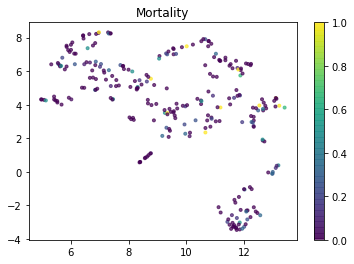

In [57]:
#h0_mean.iloc[:,2:4]=scaler.fit_transform(h0_mean.iloc[:,2:4])
#plt.scatter(h0_mean["h0_x"],h0_mean["h0_y"],c=h0_mean["y"],cmap='OrRd',alpha=0.7)
plt.scatter(h0_mean["h0_x"],h0_mean["h0_y"],c=h0_mean["y"], alpha=0.7, marker=".")
plt.colorbar()
plt.title("Mortality")

## hTでの病種別重心と死亡率

In [60]:
df=pd.DataFrame([cov,y,hT_2dim[:,0],hT_2dim[:,1]]).T

In [61]:
df.columns=["cov","y","hT_x","hT_y"]

In [62]:
df.head()

,cov,y,hT_x,hT_y
0,403,0,6.08994,7.96172
1,519,0,9.79923,5.17278
2,531,0,9.08811,8.27724
3,424,0,9.76584,11.1508
4,998,0,6.33801,5.77878


In [63]:
df["y"]=df["y"].astype(float)
df["hT_x"]=df["hT_x"].astype(float)
df["hT_y"]=df["hT_y"].astype(float)
hT_stat=df.groupby("cov").mean()

Text(0.5, 1.0, 'Mortality')

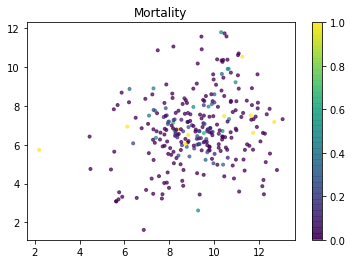

In [64]:
#hT_stat.iloc[:,1:3]=scaler.fit_transform(hT_stat.iloc[:,1:3])
#plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],cmap='OrRd',alpha=0.7)
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],alpha=0.7,marker=".")
plt.colorbar()
plt.title("Mortality")

## h1(24hour after from first record)での病種別重心と死亡率

In [65]:
df=pd.DataFrame([cov,y,h1_2dim[:,0],h1_2dim[:,1]]).T
df.columns=["cov","y","h1_x","h1_y"]
df["y"]=df["y"].astype(float)
df["h1_x"]=df["h1_x"].astype(float)
df["h1_y"]=df["h1_y"].astype(float)
h1_stat=df.groupby("cov").mean()

Text(0.5, 1.0, 'Mortality')

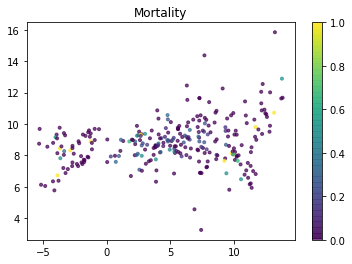

In [67]:
#h1_stat.iloc[:,1:3]=scaler.fit_transform(h1_stat.iloc[:,1:3])
#plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],cmap='OrRd',alpha=0.7)
plt.scatter(h1_stat["h1_x"],h1_stat["h1_y"],c=h1_stat["y"],alpha=0.7,marker=".")
plt.colorbar()
plt.title("Mortality")

## hTでの全点表示(一応)

In [52]:
df.iloc[:,2:4].head()

,hT_x,hT_y
0,11.846325,10.282632
1,7.893188,4.629243
2,7.408043,3.849926
3,4.693834,5.424342
4,6.857297,8.107163


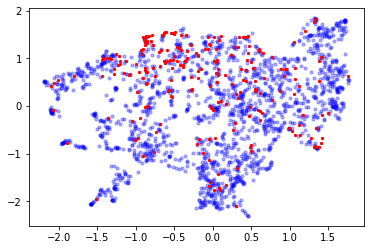

In [53]:
c=["blue","red"]
alpha=[0.3,1]
s=[10,5]
df.iloc[:,2:4]=scaler.fit_transform(df.iloc[:,2:4])
for i in range(0,2):
    plt.scatter(df[df["y"]==i]["hT_x"],df[df["y"]==i]["hT_y"],s=s[i],color=c[i],alpha=alpha[i])


In [54]:
width=0.1 # 区間幅
xmax=np.ceil(df["hT_x"].max())
xmin=np.floor(df["hT_x"].min())
ymax=np.ceil(df["hT_y"].max())
ymin=np.floor(df["hT_y"].min())
print(xmax,xmin)
print(ymax,ymin)
x=np.arange(xmin,xmax+width,width)
y=np.arange(ymin,ymax+width,width)
X,Y=np.meshgrid(x,y)
value=np.empty_like(X)
print(value.shape)

2.0 -3.0
2.0 -3.0
(51, 51)


In [55]:
for i in tqdm(range(len(y))):
    for j in range(len(x)):
        d=df[(df["hT_x"]>=x[j])& (df["hT_x"]<x[j]+width) & (df["hT_y"]>=y[i]) &(df["hT_y"]<y[i]+width)]
        if d.empty:
#            print("None")
            value[i,j]=0
        else:
#             print(d["y"].mean())
            value[i,j]=d["y"].mean()

100%|██████████| 51/51 [00:01<00:00, 31.97it/s]


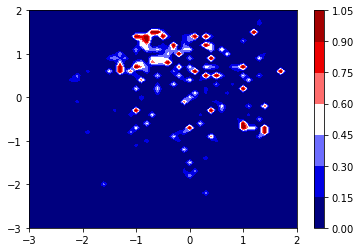

In [56]:
plt.contourf(X, Y, value,cmap="seismic")
plt.colorbar()

## 危険度マップ逆生成

In [83]:
h0_mapper=umap_obj.fit(h0)
xx=X.reshape(len(x)*len(y),1)
yy=Y.reshape(len(x)*len(y),1)
test_pts=np.hstack((xx,yy))
len(test_pts)
inv_transformed_points = h0_mapper.inverse_transform(test_pts)
inv_h0=torch.tensor(inv_transformed_points)
pred=torch.sigmoid(model.classification_model(inv_h0.to(device)))
pred=pred.cpu().detach().numpy()
pts_val=np.empty((41, 51))
idx=0
for i in tqdm(range(len(y))[::-1]):
    for j in range(len(x))[::-1]:
        pts_val[i,j]=pred[idx]
        idx+=1

100%|███████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 40983.43it/s]


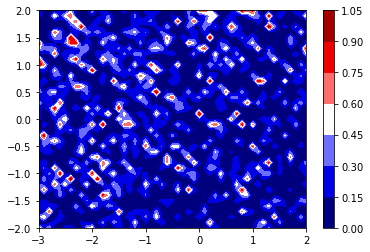

In [84]:
plt.contourf(X, Y, min_max(pts_val),cmap="seismic")
plt.colorbar()

In [76]:
hT_mapper=umap_obj.fit(hT)
xx=X.reshape(len(x)*len(y),1)
yy=Y.reshape(len(x)*len(y),1)
test_pts=np.hstack((xx,yy))
len(test_pts)
inv_transformed_points = hT_mapper.inverse_transform(test_pts)
inv_hT=torch.tensor(inv_transformed_points)
pred=torch.sigmoid(model.classification_model(inv_hT.to(device)))
pred=pred.cpu().detach().numpy()
pts_val=np.empty((41, 51))
idx=0
for i in tqdm(range(len(y))[::-1]):
    for j in range(len(x))[::-1]:
        pts_val[i,j]=pred[idx]
        idx+=1

100%|███████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 40993.20it/s]


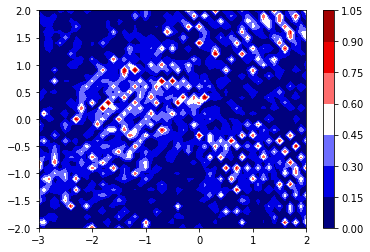

In [82]:
plt.contourf(X, Y, min_max(pts_val),cmap="seismic")
plt.colorbar()

## 病種を大分類に

In [57]:
# ICD9をshortcodeからさらに大分類に分ける a-rまで
def classifyICD(code):
    if code.isdecimal():
        code=int(code)
        if code <=139:
            return "a" #infectious and parasitic diseases
        elif code<=239:
            return "b" #neoplasms
        elif code<=279:
            return "c" #endocrine, nutritional and metabolic diseases, and immunity disorders
        elif code<=289:
            return "d" #Diseases of the Blood and Blood-forming Organs
        elif code<=319:
            return  "e"#Mental Disorders
        elif code<= 359:
            return "f"# diseases of the nervous system
        elif code<= 389:
            return  "g"#sense organs
        elif code<= 459:
            return "h"# Diseases of the Circulatory System
        elif code<= 519 :
            return  "i"# Diseases of the Respiratory System
        elif code<= 579:
            return "j"# Diseases of the Digestive System
        elif code<= 629:
            return "k"# Diseases of the Genitourinary System
        elif code<= 679:
            return  "l"# Complications of Pregnancy, Childbirth, and the Puerperium
        elif code<= 709:
            return "m"#Diseases of the Skin and Subcutaneous Tissue
        elif code<= 739:
            return  "n"# Diseases of the Musculoskeletal System and Connective Tissue
        elif code<= 759:
            return  "o"# Congenital Anomalies
        elif code<= 779:
            return  "p"#Certain Conditions originating in the Perinatal Period
        elif code<= 799:
            return  "q"#Symptoms, Signs and Ill-defined Conditions
        elif code<= 999:
            return  "r"#Injury and Poisoning
    else:
        return "others"

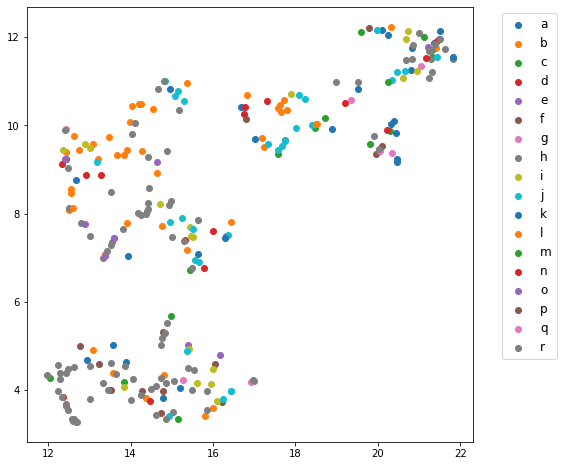

In [58]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean["category"]=h0_mean["cov"].map(classifyICD)
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(h0_mean[h0_mean["category"]==char]["h0_x"],h0_mean[h0_mean["category"]==char]["h0_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

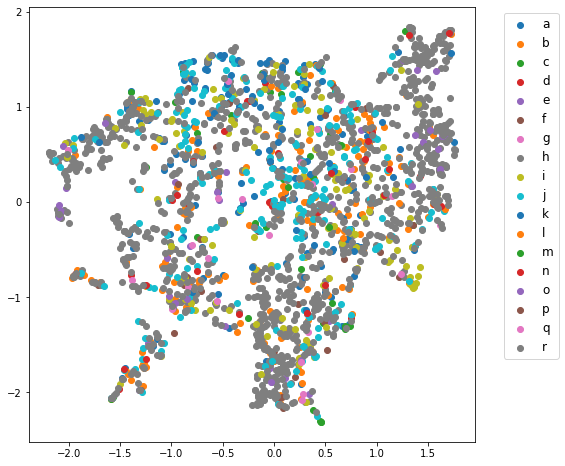

In [59]:
df_hT=copy.deepcopy(df)
df_hT["category"]=df_hT["cov"].map(classifyICD)
df_hT.head()
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(df_hT[df_hT["category"]==char]["hT_x"],df_hT[df_hT["category"]==char]["hT_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

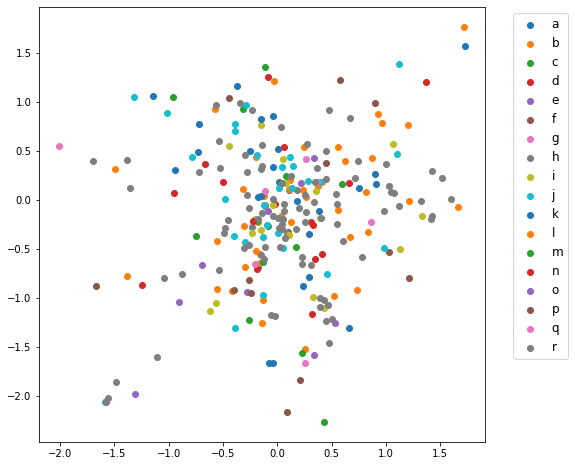

In [60]:
df_hT=copy.deepcopy(df)
df_hT=df_hT.groupby("cov").mean().reset_index()
df_hT["category"]=df_hT["cov"].map(classifyICD)
plt.figure(figsize=(8,8))
for char in "abcdefghijklmnopqr":
    plt.scatter(df_hT[df_hT["category"]==char]["hT_x"],df_hT[df_hT["category"]==char]["hT_y"],label=char)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=12)

## UMAP

In [ ]:
import umap
umap_obj=umap.UMAP()
h0_2dim=umap_obj.fit_transform(h0)
hT_2dim=umap_obj.fit_transform(hT)

## 病種での死亡率(h0)

In [ ]:
h0_2dim_df=pd.DataFrame(h0_2dim)
len(h0_2dim_df)

In [ ]:
h0_df_agg.iloc[: ,0]

In [ ]:
h0_mean=pd.concat([h0_df_agg.iloc[: ,0:2],h0_2dim_df],axis=1)
h0_mean.columns=["cov", "y","h0_x","h0_y"]
h0_mean

In [ ]:
plt.scatter(h0_mean["h0_x"],h0_mean["h0_y"],c=h0_mean["y"],cmap='Reds')
plt.colorbar()

## hTでの病種別重心と死亡率

In [ ]:
df=pd.DataFrame([cov,y,hT_2dim[:,0],hT_2dim[:,1]]).T

In [ ]:
df.columns=["cov","y","hT_x","hT_y"]

In [ ]:
df["y"]=df["y"].astype(float)
df["hT_x"]=df["hT_x"].astype(float)
df["hT_y"]=df["hT_y"].astype(float)
hT_stat=df.groupby("cov").mean()

In [ ]:
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=hT_stat["y"],cmap='seismic')
plt.colorbar()
plt.title("Mortality")

In [ ]:
plt.scatter(hT_stat["hT_x"],hT_stat["hT_y"],c=list(hT_stat.index),cmap='seismic')
plt.colorbar()
plt.title("cov")

In [121]:
def draw_umap(data,label ,n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure(figsize=(8,8))
    cmap="cool"
    if n_components == 1:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], range(len(u)), c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 2:
#         ax = fig.add_subplot(111)
        plt.scatter(u[:,0], u[:,1],c=label,cmap=cmap)
        plt.colorbar()
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=label, s=100,cmap=cmap)


    plt.title(title, fontsize=18)

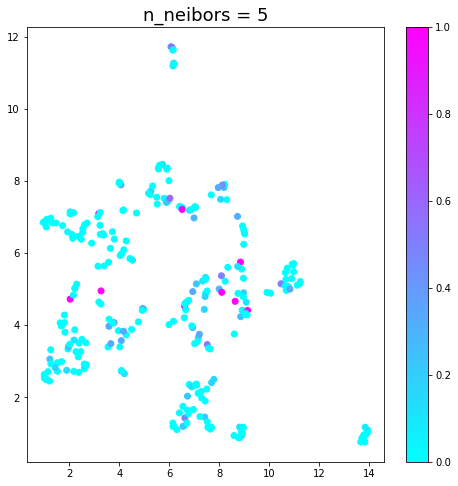

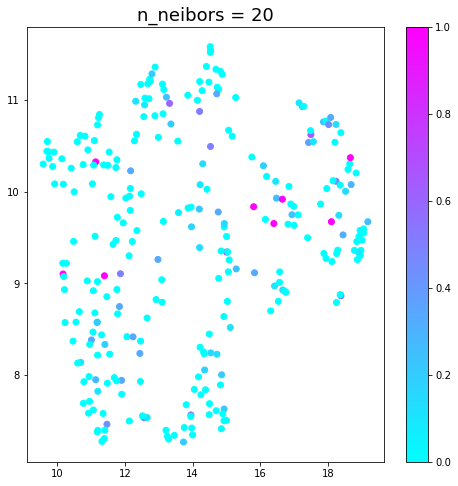

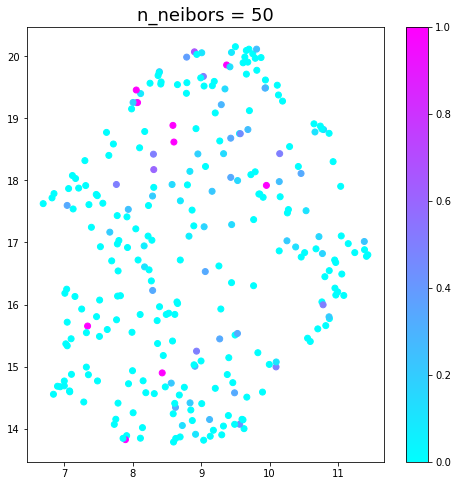

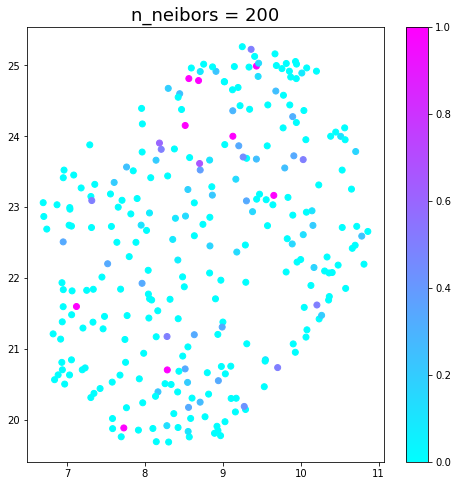

In [122]:
for n in ( 5,  20, 50,  200):
    draw_umap(h0,h0_mean["y"],n_neighbors=n ,title=f"n_neibors = {n}")

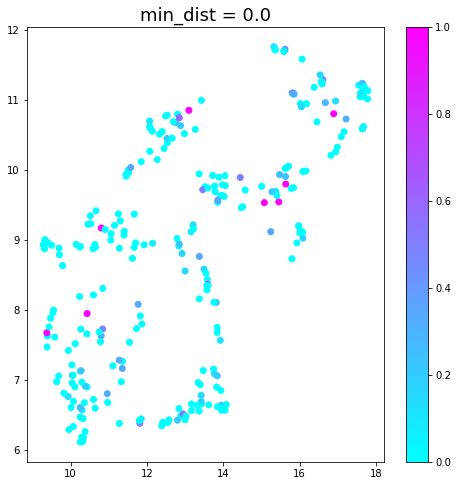

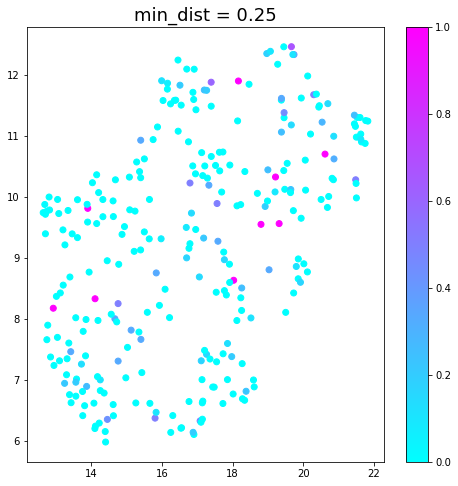

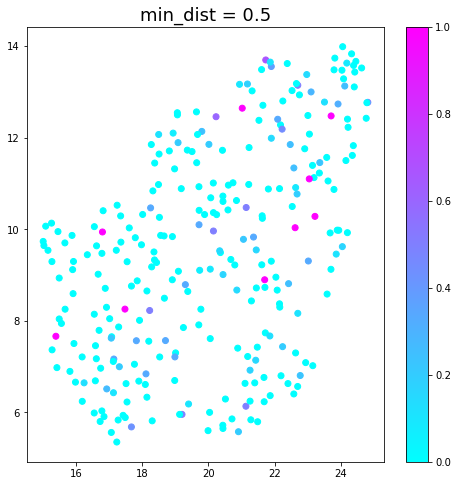

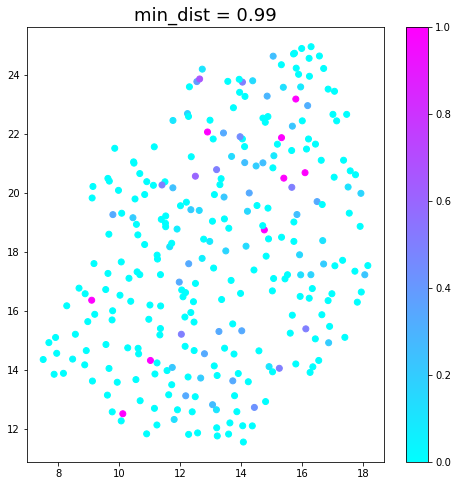

In [123]:
for d in (0.0,  0.25, 0.5, 0.99):
    draw_umap(h0,h0_mean["y"], min_dist=d , title='min_dist = {}'.format(d))

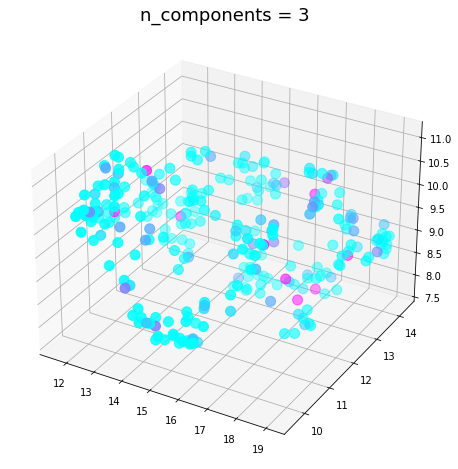

In [124]:
draw_umap(h0,h0_mean["y"],min_dist=0.2,n_components=3, title='n_components = 3')